In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

from echoes import ESNRegressor
from bioRNN.tasks.memory.capacity import make_X_y, forgetting
from bioRNN.utils import (
    load_connectome,
    CONNECTOMES_PATH,
    make_bioRRNs,
    make_memory_capacity_scorer,
    cv_generator,
    remove_transient
)
sns.set(style="ticks", font_scale=1)#, context="paper")

In [2]:
[
    load_connectome("macaque").shape,
    load_connectome("human").shape,
    load_connectome("marmoset").shape
]

[(29, 29), (57, 57), (55, 55)]

In [3]:
#make_X = partial(np.random.binomial, 1, .5, size=1_500)

In [4]:
Ws = make_bioRRNs(connectome_name="human", neuron_density=1, rand_partition=True)
Ws.keys()

dict_keys(['W_bio_rank', 'W_bio_norank', 'W_rnd_density', 'W_rnd_k', 'W_rnd_full'])

In [11]:
lags=np.arange(5, 31)#0, 201, 20)
X, y = make_X_y(
    make_X=partial(np.random.uniform, low=-.5, high=.5, size=5_000),
    lags=lags,
    cut=0
)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 1), (1000, 1), (4000, 26), (1000, 26))

<timed exec>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
<timed exec>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
<timed exec>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a u

CPU times: user 3.17 s, sys: 2.63 s, total: 5.8 s
Wall time: 960 ms


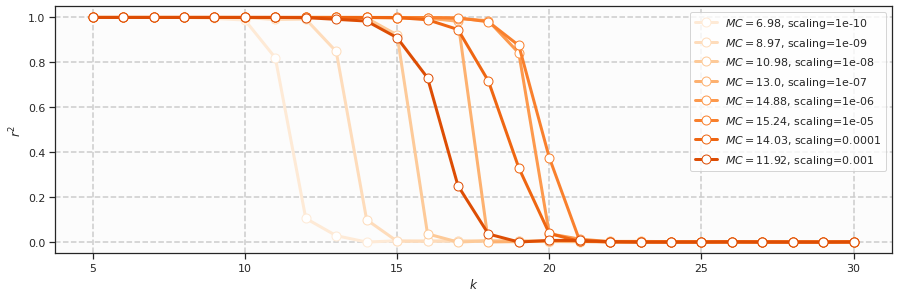

In [12]:
%%time

n_transient = 100

plt.figure(figsize=(15, 10))

colors = (c for i,c in enumerate(sns.color_palette("Oranges", 10)))
    
#for W_name, W in Ws.items():
for scaling in 10. ** np.arange(-10, -2):
    c = next(colors)
    esn = ESNRegressor(
        W=Ws["W_rnd_k"],
        bias=1,
        n_transient=n_transient, 
        spectral_radius=.99,
        input_scaling=scaling,        
    ).fit(X_train, y_train)

    y_pred = esn.predict(X_test)

    forget_curve, mc = forgetting(y_test[n_transient:], y_pred[n_transient:])
    plt.subplot(211)
    plt.plot(
        lags, 
        forget_curve, 
        #"o", 
        color=c, 
        linewidth=3, 
        linestyle="-", 
        markerfacecolor="white", 
        markeredgecolor=c,
        markersize=9,
        marker="o",
        label=r"$MC = $" + f"{round(mc, 2)}, scaling={scaling}"
    )
    #marker="s")
#    plt.fill_between(
#        lags, 
#        forget_curve, 
#        color=c,
#        alpha=.2, 
#        label=r"$MC = $" + f"{round(mc, 2)}, W={W_name}")
    plt.ylabel(r"$r^2$")
    plt.xlabel(r"$k$")
    plt.grid(which="both", 
             #axis="y", 
             linestyle="--", 
             linewidth=1.5)


    plt.legend(loc=1)
#    plt.subplot(212)
#    plt.plot(
#        pd.DataFrame(np.gradient(forget_curve, lags)).rolling(window=1).mean(), 
#        c=c, 
#        linewidth=.5
#    )
    #plt.xticks(lags[::10],labels=lags[::10])
    #plt.yscale("log");
ax = plt.gca()
ax.set_facecolor(".99")

## GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

In [29]:
scorer = make_memory_capacity_scorer(n_transient=100) 
param_grid = dict(
    W=list(Ws.values()), 
    bias=[0], 
    n_transient=[100], 
    spectral_radius=[.95]
)

#scorer = make_memory_capacity_scorer(n_transient=100)
cv = cv_generator(X_train, test_size=.2)
grid = GridSearchCV(
    ESNRegressor(),
    param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-2,
    refit=False,
    verbose=0
).fit(X_train, y_train)

In [30]:
from bioRNN.utils import label_W_df, clean_df_param_names

In [31]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_W,param_bias,param_n_transient,param_spectral_radius,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,2.088462,0.0,0.033942,0.0,"[[0.0, 0.09526254088463533, 0.055568181406569,...",0,100,0.95,"{'W': [[0.0, 0.09526254088463533, 0.0555681814...",10.872132,10.872132,0.0,5
1,1.683950,0.0,0.035869,0.0,"[[0.0, 0.591406531169538, 0.005494274999562343...",0,100,0.95,"{'W': [[0.0, 0.591406531169538, 0.005494274999...",19.538471,19.538471,0.0,3
2,1.662252,0.0,0.038050,0.0,"[[0.0, 0.0, 0.005494274999562343, -0.382016284...",0,100,0.95,"{'W': [[0.0, 0.0, 0.005494274999562343, -0.382...",19.971938,19.971938,0.0,1
3,1.673794,0.0,0.039644,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25828236631...",0,100,0.95,"{'W': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25828...",19.966616,19.966616,0.0,2
4,2.070012,0.0,0.037139,0.0,"[[-0.40231483313353444, 0.591406531169538, 0.0...",0,100,0.95,"{'W': [[-0.40231483313353444, 0.59140653116953...",18.076288,18.076288,0.0,4


In [32]:
label_W_df(clean_df_param_names(pd.DataFrame(grid.cv_results_)), Ws)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,W,bias,n_transient,spectral_radius,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,2.088462,0.0,0.033942,0.0,bio_rank,0,100,0.95,"{'W': [[0.0, 0.09526254088463533, 0.0555681814...",10.872132,10.872132,0.0,5
1,1.683950,0.0,0.035869,0.0,bio_norank,0,100,0.95,"{'W': [[0.0, 0.591406531169538, 0.005494274999...",19.538471,19.538471,0.0,3
2,1.662252,0.0,0.038050,0.0,rnd_density,0,100,0.95,"{'W': [[0.0, 0.0, 0.005494274999562343, -0.382...",19.971938,19.971938,0.0,1
3,1.673794,0.0,0.039644,0.0,rnd_k,0,100,0.95,"{'W': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25828...",19.966616,19.966616,0.0,2
4,2.070012,0.0,0.037139,0.0,rnd_full,0,100,0.95,"{'W': [[-0.40231483313353444, 0.59140653116953...",18.076288,18.076288,0.0,4


In [81]:
import os
from fastcore.utils import Path

In [84]:
p = Path(os.environ["DATAICNS"])/"bioRNN/memory-capacity/results/evaluation"

In [89]:
data = pd.read_csv(p.ls()[0])
data.head(3)

,connectome,rand_partition,neuron_density,W,bias,n_transient,spectral_radius,mean_test_memory_capacity
0,macaque,True,1,bio_rank,0,100,0.99,7.224977
1,macaque,True,1,bio_norank,0,100,0.99,12.755730
2,macaque,True,1,rnd_density,0,100,0.99,10.713157


In [90]:
data["mc"] = data.mean_test_memory_capacity

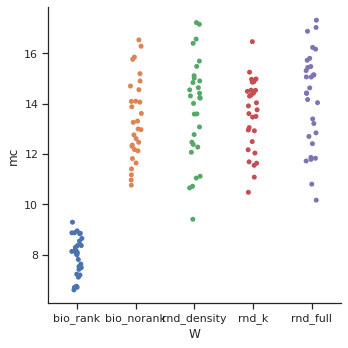

In [93]:
sns.catplot(  
    x="W",
    y="mc",
    data=data,
)